In [5]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import os.path
import pycountry
import time

from tqdm import tqdm
from sklearn.linear_model import LinearRegression

# Define the base URL and your API token
base_url = "https://api.iucnredlist.org/api/v4/habitats/"
token = "TVXuHMNVpyvNRFTdwx8SED3kt5mPNJ3W1QJL"

# Set up the headers with the token
headers = {
    "accept": "application/json",
    "Authorization": token
}

# Function to convert country code to country name
def get_country_name(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return 'Unknown'

# Function to get assessments for a given habitat
def get_assessments(habitat_id):
    page = 1
    per_page = 100
    assessments = []
    
    while True:
        print(f"Habitat: {habitat_id}, Page: {page}")
        # Construct the URL with pagination parameters
        url = f"{base_url}{habitat_id}?page={page}&per_page={per_page}"
        
        # Make the GET request
        response = requests.get(url, headers=headers)
        
        # Check if the request was successful
        if response.status_code == 200:
            data = response.json()
            assessments.extend(data.get('assessments', []))
            
            # Check if we have reached the last page
            total_pages = int(response.headers.get('total-pages', 1))
            if page >= total_pages:
                break
            
            # Move to the next page
            page += 1
        else:
            print(f"Failed to retrieve data for habitat {habitat_id}: {response.status_code} - {response.text}")
            break
            
    return assessments

In [6]:
# Get marine assessments

if not os.path.exists("../Data/marine_habitats.csv"):
    # Initialize variables for storing all assessments
    all_assessments = []
    
    # Iterate through major categories and their subcategories
    major_habitats = [9, 10, 11, 12, 13]
    for habitat_id in major_habitats:
        # Get assessments for the main category
        all_assessments.extend(get_assessments(habitat_id))
        
        # Check for subcategories (assuming subcategories range from 1 to 15)
        for sub_id in range(1, 16):
            sub_habitat_id = f"{habitat_id}_{sub_id}"
            all_assessments.extend(get_assessments(sub_habitat_id))
    
    # Extract relevant information for each assessment
    rows = []
    for assessment in all_assessments:
        row = {
            "year_published": assessment.get("year_published"),
            "latest": assessment.get("latest"),
            "sis_taxon_id": assessment.get("sis_taxon_id"),
            "url": assessment.get("url"),
            "assessment_id": assessment.get("assessment_id"),
            "code": assessment.get("code"),
            "code_type": assessment.get("code_type"),
            "scope_description": assessment.get("scopes")[0].get("description").get("en") if assessment.get("scopes") else None,
            "scope_code": assessment.get("scopes")[0].get("code") if assessment.get("scopes") else None,
            "habitat_id": assessment.get("habitat_id"),  # Add habitat_id to the row
        }
        rows.append(row)
    
    # Create a DataFrame
    marine_df = pd.DataFrame(rows)
    marine_df.to_csv("../Data/marine_habitats.csv")
    marine_df
else:
    marine_df = pd.read_csv("../Data/marine_habitats.csv")
    marine_df

In [7]:
base_url = "https://api.iucnredlist.org/api/v4/assessment"

# Assuming df_combined is defined elsewhere in your code
assessements_list = marine_df.loc[marine_df.groupby('sis_taxon_id')['year_published'].idxmax()].reset_index(drop=True)

# List of assessment IDs
assessment_ids = assessements_list['assessment_id'].dropna().astype(int).values

# Initialize empty lists to hold all the data if not already defined
try:
    all_data
except NameError:
    all_data = []

try:
    all_data_threats
except NameError:
    all_data_threats = []

# Extract processed assessment_ids from all_data
processed_assessment_ids = {entry["assessment_id"] for entry in all_data}

def fetch_data_with_retry(url, headers, retries=5, backoff_factor=0.5):
    for i in range(retries):
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            return response.json()
        elif response.status_code == 429:
            wait_time = backoff_factor * (2 ** i)
            print(f"Rate limit exceeded. Retrying in {wait_time} seconds...")
            time.sleep(wait_time)
        else:
            print(f"Failed to retrieve data: {response.status_code} - {response.text}")
            break
    return None

if not os.path.exists("../Data/all_threats_species.csv"):
    for assessment_id in tqdm(assessment_ids):
        # Skip if the assessment_id is already processed
        if assessment_id in processed_assessment_ids:
            continue
    
        # Construct the URL for the current assessment ID
        url = f"{base_url}/{assessment_id}"
        
        # Fetch the data with retry mechanism
        data = fetch_data_with_retry(url, headers)
        
        if data:
            trend = data.get("population_trend") if data.get("population_trend") is None else data.get("population_trend").get("code")
            class_name = data.get("taxon", {}).get("class_name")
            sis_taxon_id = data.get("sis_taxon_id", [])
            locations = data.get("locations", [])
            threats = data.get("threats", [])
            status = data.get("red_list_category", {}).get("code")
            year_published = data.get("year_published", [])
    
            # Extract the common English name (if available)
            common_names = data.get("taxon", {}).get("common_names", [])
            english_common_name = next((name['name'] for name in common_names if name['language']['code'] == 'eng'), None)
            
            # Add the assessment data to the list
            for location in locations:
                country_code = location.get("code")
                assessment_data = {
                    "assessment_id": assessment_id,
                    "sis_taxon_id": sis_taxon_id,
                    "country_code": country_code,
                    "trend": trend,
                    "class_name": class_name,
                    "status": status,
                    "year_published": year_published,
                    "english_common_name": english_common_name  # Store the common English name here
                }
                all_data.append(assessment_data)
    
            # Add the threats data to the list
            for location in locations:
                country_code = location.get("code")
                for threat in threats:
                    threat_code = threat.get("code")
                    threat_data = {
                        "assessment_id": assessment_id,
                        "sis_taxon_id": sis_taxon_id,
                        "country_code": country_code,
                        "threat_code": threat_code,
                        "class_name": class_name,
                        "year_published": year_published,
                        "english_common_name": english_common_name  # Store the common English name here
                    }
                    all_data_threats.append(threat_data)
            
            # Mark the assessment_id as processed
            processed_assessment_ids.add(assessment_id)
    
    # Create DataFrames from the collected data
    trends_df = pd.DataFrame(all_data)
    threats_df = pd.DataFrame(all_data_threats)
    trends_df.to_csv("../Data/all_trends_species.csv")
    threats_df.to_csv("../Data/all_threats_species.csv")
else:
    trends_df = pd.read_csv("../Data/all_trends_species.csv")
    threats_df = pd.read_csv("../Data/all_threats_species.csv")

  5%|██████                                                                                                                      | 893/18106 [08:26<2:37:37,  1.82it/s]

Rate limit exceeded. Retrying in 0.5 seconds...


  6%|██████▉                                                                                                                    | 1013/18106 [09:23<2:26:19,  1.95it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


  8%|██████████                                                                                                                 | 1478/18106 [13:23<1:51:50,  2.48it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


  9%|██████████▊                                                                                                                | 1598/18106 [14:25<2:35:19,  1.77it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...


 12%|███████████████▏                                                                                                           | 2243/18106 [20:23<2:05:57,  2.10it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


 13%|████████████████                                                                                                           | 2363/18106 [21:23<2:07:58,  2.05it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


 14%|████████████████▊                                                                                                          | 2483/18106 [22:23<2:00:40,  2.16it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


 14%|█████████████████▋                                                                                                         | 2603/18106 [23:25<2:01:02,  2.13it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...


 15%|██████████████████▍                                                                                                        | 2723/18106 [24:26<1:53:36,  2.26it/s]

Rate limit exceeded. Retrying in 0.5 seconds...


 16%|███████████████████▎                                                                                                       | 2843/18106 [25:23<1:51:50,  2.27it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


 16%|████████████████████▏                                                                                                      | 2963/18106 [26:26<2:03:26,  2.04it/s]

Rate limit exceeded. Retrying in 0.5 seconds...


 19%|███████████████████████▎                                                                                                   | 3438/18106 [30:23<1:48:15,  2.26it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


 20%|████████████████████████▏                                                                                                  | 3558/18106 [31:22<1:41:23,  2.39it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...
Rate limit exceeded. Retrying in 4.0 seconds...


 20%|████████████████████████▉                                                                                                  | 3678/18106 [32:24<2:00:09,  2.00it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


 21%|█████████████████████████▊                                                                                                 | 3798/18106 [33:24<1:44:55,  2.27it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


 22%|██████████████████████████▌                                                                                                | 3918/18106 [34:21<1:48:43,  2.17it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...
Rate limit exceeded. Retrying in 4.0 seconds...


 23%|████████████████████████████▋                                                                                              | 4225/18106 [38:24<2:01:55,  1.90it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...


 25%|██████████████████████████████▎                                                                                            | 4463/18106 [40:26<1:49:46,  2.07it/s]

Rate limit exceeded. Retrying in 0.5 seconds...


 25%|███████████████████████████████▏                                                                                           | 4583/18106 [41:25<1:51:15,  2.03it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...


 30%|█████████████████████████████████████                                                                                      | 5451/18106 [49:17<1:30:56,  2.32it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...
Rate limit exceeded. Retrying in 4.0 seconds...
Rate limit exceeded. Retrying in 8.0 seconds...


 31%|██████████████████████████████████████▋                                                                                    | 5690/18106 [51:26<1:59:34,  1.73it/s]

Rate limit exceeded. Retrying in 0.5 seconds...


 33%|█████████████████████████████████████████                                                                                  | 6044/18106 [54:23<1:23:13,  2.42it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


 34%|█████████████████████████████████████████▊                                                                                 | 6164/18106 [55:22<1:19:20,  2.51it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


 35%|██████████████████████████████████████████▋                                                                                | 6284/18106 [56:21<1:32:53,  2.12it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...
Rate limit exceeded. Retrying in 4.0 seconds...


 35%|███████████████████████████████████████████▌                                                                               | 6404/18106 [57:25<1:27:44,  2.22it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...


 36%|████████████████████████████████████████████▎                                                                              | 6524/18106 [58:17<1:16:06,  2.54it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...
Rate limit exceeded. Retrying in 4.0 seconds...
Rate limit exceeded. Retrying in 8.0 seconds...


 37%|█████████████████████████████████████████████▏                                                                           | 6765/18106 [1:00:19<1:24:02,  2.25it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...
Rate limit exceeded. Retrying in 4.0 seconds...


 38%|██████████████████████████████████████████████                                                                           | 6885/18106 [1:01:21<1:33:05,  2.01it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...
Rate limit exceeded. Retrying in 4.0 seconds...


 39%|███████████████████████████████████████████████▌                                                                         | 7125/18106 [1:03:22<1:21:42,  2.24it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...
Rate limit exceeded. Retrying in 4.0 seconds...


 41%|█████████████████████████████████████████████████▏                                                                       | 7365/18106 [1:05:21<1:16:26,  2.34it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...
Rate limit exceeded. Retrying in 4.0 seconds...


 41%|██████████████████████████████████████████████████                                                                       | 7485/18106 [1:06:23<1:16:40,  2.31it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


 42%|██████████████████████████████████████████████████▊                                                                      | 7605/18106 [1:07:19<1:18:06,  2.24it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...
Rate limit exceeded. Retrying in 4.0 seconds...


 43%|████████████████████████████████████████████████████▎                                                                    | 7829/18106 [1:09:25<1:16:04,  2.25it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...


 45%|█████████████████████████████████████████████████████▉                                                                   | 8064/18106 [1:11:27<1:22:10,  2.04it/s]

Rate limit exceeded. Retrying in 0.5 seconds...


 46%|████████████████████████████████████████████████████████▏                                                                | 8414/18106 [1:14:26<1:27:41,  1.84it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...


 47%|█████████████████████████████████████████████████████████                                                                | 8534/18106 [1:15:23<1:14:06,  2.15it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


 48%|█████████████████████████████████████████████████████████▊                                                               | 8654/18106 [1:16:21<1:10:22,  2.24it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...
Rate limit exceeded. Retrying in 4.0 seconds...


 48%|██████████████████████████████████████████████████████████▋                                                              | 8774/18106 [1:17:26<1:08:53,  2.26it/s]

Rate limit exceeded. Retrying in 0.5 seconds...


 49%|███████████████████████████████████████████████████████████▍                                                             | 8894/18106 [1:18:23<1:11:05,  2.16it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


 50%|████████████████████████████████████████████████████████████▏                                                            | 9014/18106 [1:19:23<1:19:50,  1.90it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


 51%|█████████████████████████████████████████████████████████████▊                                                           | 9253/18106 [1:21:27<1:23:47,  1.76it/s]

Rate limit exceeded. Retrying in 0.5 seconds...


 55%|██████████████████████████████████████████████████████████████████▍                                                      | 9934/18106 [1:27:26<1:14:57,  1.82it/s]

Rate limit exceeded. Retrying in 0.5 seconds...


 56%|███████████████████████████████████████████████████████████████████▍                                                    | 10170/18106 [1:29:26<1:01:03,  2.17it/s]

Rate limit exceeded. Retrying in 0.5 seconds...


 59%|███████████████████████████████████████████████████████████████████████▌                                                  | 10621/18106 [1:33:21<57:54,  2.15it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...
Rate limit exceeded. Retrying in 4.0 seconds...


 59%|████████████████████████████████████████████████████████████████████████▎                                                 | 10741/18106 [1:34:25<56:38,  2.17it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...


 62%|██████████████████████████████████████████████████████████████████████████▏                                             | 11202/18106 [1:38:25<1:03:17,  1.82it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...


 75%|███████████████████████████████████████████████████████████████████████████████████████████▏                              | 13541/18106 [1:59:24<33:19,  2.28it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


 75%|████████████████████████████████████████████████████████████████████████████████████████████                              | 13661/18106 [2:00:22<33:58,  2.18it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


 76%|████████████████████████████████████████████████████████████████████████████████████████████▊                             | 13781/18106 [2:01:20<32:57,  2.19it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...
Rate limit exceeded. Retrying in 4.0 seconds...


 77%|█████████████████████████████████████████████████████████████████████████████████████████████▋                            | 13901/18106 [2:02:25<38:14,  1.83it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...


 79%|████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 14373/18106 [2:06:26<31:01,  2.01it/s]

Rate limit exceeded. Retrying in 0.5 seconds...


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 14831/18106 [2:10:26<23:50,  2.29it/s]

Rate limit exceeded. Retrying in 0.5 seconds...


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 15413/18106 [2:15:25<19:09,  2.34it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 15533/18106 [2:16:23<21:11,  2.02it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 15653/18106 [2:17:26<21:32,  1.90it/s]

Rate limit exceeded. Retrying in 0.5 seconds...


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 15773/18106 [2:18:21<19:28,  2.00it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...
Rate limit exceeded. Retrying in 4.0 seconds...


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████               | 15893/18106 [2:19:24<15:13,  2.42it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 16013/18106 [2:20:21<17:51,  1.95it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...
Rate limit exceeded. Retrying in 4.0 seconds...


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 16133/18106 [2:21:25<15:19,  2.15it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 16253/18106 [2:22:16<12:17,  2.51it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...
Rate limit exceeded. Retrying in 4.0 seconds...
Rate limit exceeded. Retrying in 8.0 seconds...


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 16487/18106 [2:24:24<10:39,  2.53it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 16607/18106 [2:25:21<10:03,  2.49it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...
Rate limit exceeded. Retrying in 4.0 seconds...


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 16727/18106 [2:26:24<11:09,  2.06it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 16847/18106 [2:27:24<10:24,  2.02it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 16967/18106 [2:28:22<08:23,  2.26it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 17087/18106 [2:29:19<07:36,  2.23it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...
Rate limit exceeded. Retrying in 4.0 seconds...


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 17207/18106 [2:30:17<05:49,  2.57it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...
Rate limit exceeded. Retrying in 4.0 seconds...
Rate limit exceeded. Retrying in 8.0 seconds...


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 17328/18106 [2:31:26<06:15,  2.07it/s]

Rate limit exceeded. Retrying in 0.5 seconds...


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 17448/18106 [2:32:25<05:24,  2.03it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 17568/18106 [2:33:24<04:14,  2.12it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 17688/18106 [2:34:24<04:04,  1.71it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 17808/18106 [2:35:25<02:12,  2.25it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 17928/18106 [2:36:21<01:10,  2.53it/s]

Rate limit exceeded. Retrying in 0.5 seconds...
Rate limit exceeded. Retrying in 1.0 seconds...
Rate limit exceeded. Retrying in 2.0 seconds...
Rate limit exceeded. Retrying in 4.0 seconds...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18106/18106 [2:37:53<00:00,  1.91it/s]


## Figure 1

In [25]:
trends_df = trends_df[["assessment_id","year_published","sis_taxon_id","country_code","status","class_name","english_common_name","trend"]]#.merge(df_unique[["assessment_id","year_published","sis_taxon_id"]], on="assessment_id", how="inner")
trends_df['year_published'] = trends_df['year_published'].astype(int)

# Mapping dictionary
threats_mapping = {
    'DD': 'Data Deficient',
    'LC': 'Least Concern',
    'NT': 'Near Threatened',
    'VU': 'Vulnerable',
    'EN': 'Endangered',
    'CR': 'Critically Endangered',
    'EW': 'Extinct in the Wild',
    'EX': 'Extinct',
    'NE': 'Not Evaluated',
}

# Replace the values in the 'Threat' column
trends_df['Threat'] = trends_df['status'].replace(threats_mapping)

trends_df.loc[trends_df["trend"] == 0, 'trend_title'] = "Increasing"
trends_df.loc[trends_df["trend"] == 1, 'trend_title'] = "Decreasing"
trends_df.loc[trends_df["trend"] == 2, 'trend_title'] = "Stable"
trends_df.loc[trends_df["trend"] == 3, 'trend_title'] = "Unknown"

# Initialize an empty list to store new rows
new_rows = []

# Define the range of years
years = range(1997, 2025)

# Iterate through each sis_taxon_id
for sis_taxon_id in tqdm(trends_df['sis_taxon_id'].unique()):
    # Filter data for the current sis_taxon_id
    df_sis = trends_df[trends_df['sis_taxon_id'] == sis_taxon_id]
    
    # Iterate through each year in the defined range
    for year in years:
        # Check if there is an entry for the current year
        if year not in df_sis['year_published'].values:
            # Find the most recent threat categorization from a previous year
            previous_threats = df_sis[df_sis['year_published'] < year]
            if not previous_threats.empty:
                last_threat = previous_threats.iloc[-1]['Threat']
                class_name = previous_threats.iloc[-1]['class_name']
                country_code = previous_threats.iloc[-1]['country_code']
                english_common_name = previous_threats.iloc[-1]['english_common_name']
                trend_title = previous_threats.iloc[-1]['trend_title']
                # Create a new row with the current year, sis_taxon_id, and the most recent threat categorization
                new_row = {
                    'year_published': year,
                    'Threat': last_threat,
                    'sis_taxon_id': sis_taxon_id,
                    'class_name': class_name,
                    "country_code": country_code,
                    "english_common_name": english_common_name,
                    "trend_title": trend_title,
                }
                new_rows.append(new_row)

# Create a DataFrame from the new rows
df_new_rows = pd.DataFrame(new_rows)

# Append the new rows to the original dataframe
df_combined = pd.concat([trends_df, df_new_rows])

# Sort the combined dataframe
df_combined = df_combined.sort_values(by=['sis_taxon_id', 'year_published']).reset_index(drop=True)

# Apply the function to the country_code column
df_combined['country_name'] = df_combined['country_code'].apply(get_country_name)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17975/17975 [00:53<00:00, 333.37it/s]


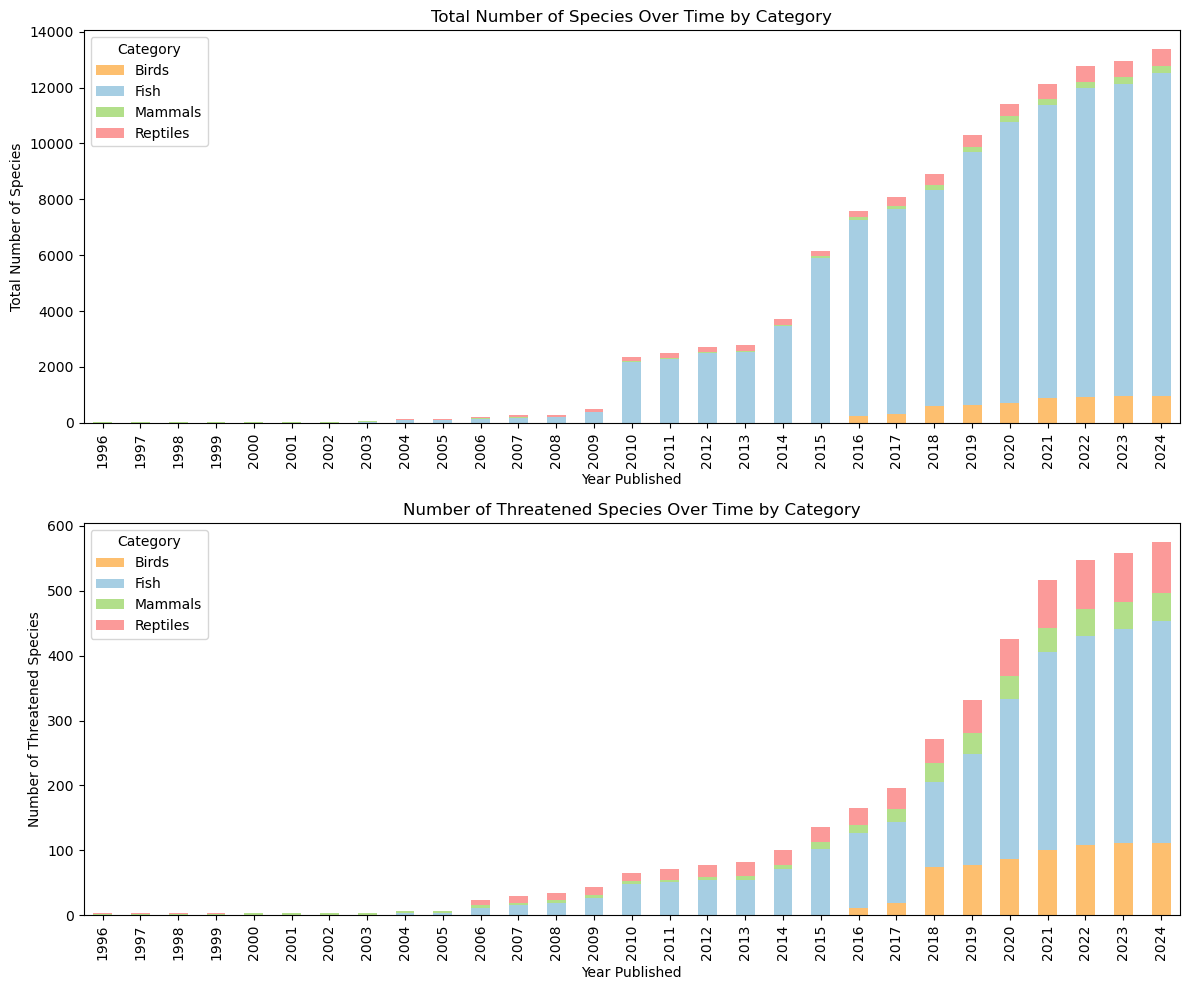

In [26]:
# Define the mapping
class_to_category = {
    'ACTINOPTERYGII': 'Fish', 
    'CHONDRICHTHYES': 'Fish', 
    'SARCOPTERYGII': 'Fish', 
    'PETROMYZONTI': 'Fish',
    'MYXINI': 'Fish',
    'CEPHALASPIDOMORPHI': 'Fish',
    'MAMMALIA': 'Mammals', 
    'REPTILIA': 'Reptiles', 
    'AVES': 'Birds'
}

df_combined = df_combined.drop_duplicates(["sis_taxon_id","year_published"]).merge(marine_df.drop_duplicates("sis_taxon_id")[["sis_taxon_id"]],on='sis_taxon_id',how='inner')

# Map the class names to categories
df_combined['category'] = df_combined['class_name'].map(class_to_category)

# Remove rows where category is NaN (those not in the specified classes)
df_combined = df_combined.dropna(subset=['category'])

# Create a pivot table for the total counts of species across all years and categories
pivot_total = df_combined.pivot_table(index='year_published', columns='category', aggfunc='size', fill_value=0)

# Filter the data for specific threats
filtered_df = df_combined[df_combined['Threat'].isin(['Critically Endangered', 'Endangered', 'EW', 'EX'])]

# Create a pivot table for the filtered (threatened) species
pivot_filtered = filtered_df.pivot_table(index='year_published', columns='category', aggfunc='size', fill_value=0)

# Define the pastel colors
colors = {
    'Fish': '#a6cee3',      # pastel blue
    'Mammals': '#b2df8a',   # pastel green
    'Reptiles': '#fb9a99',  # pastel red
    'Birds': '#fdbf6f'      # pastel yellow
}

# Plot the total counts of species across all categories and years
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
pivot_total.plot(kind='bar', stacked=True, figsize=(12, 10), color=[colors.get(x, '#ffffff') for x in pivot_total.columns], ax=plt.gca())
plt.title('Total Number of Species Over Time by Category')
plt.xlabel('Year Published')
plt.ylabel('Total Number of Species')
plt.legend(title='Category')

# Plot the filtered (threatened) species counts
plt.subplot(2, 1, 2)
pivot_filtered.plot(kind='bar', stacked=True, figsize=(12, 10), color=[colors.get(x, '#ffffff') for x in pivot_filtered.columns], ax=plt.gca())
plt.title('Number of Threatened Species Over Time by Category')
plt.xlabel('Year Published')
plt.ylabel('Number of Threatened Species')
plt.legend(title='Category')

# Adjust layout and save the plot as a PDF
plt.tight_layout()
plt.savefig('species_comparison_histogram.pdf')

# Show the plot
plt.show()


In [27]:
pivot_filtered['All'] = (pivot_filtered["Birds"] + pivot_filtered["Fish"] + pivot_filtered["Mammals"] + pivot_filtered["Reptiles"])
pivot_total['All'] = (pivot_total["Birds"] + pivot_total["Fish"] + pivot_total["Mammals"] + pivot_total["Reptiles"])

pivot_percent = (pivot_filtered / pivot_total)
protect_marine_life_df = pivot_percent.reset_index()
X_years=protect_marine_life_df["year_published"].values.reshape([-1,1])
y_counts=(pivot_filtered["Birds"] + pivot_filtered["Fish"] + pivot_filtered["Mammals"] + pivot_filtered["Reptiles"]).values/\
    (pivot_total["Birds"] + pivot_total["Fish"] + pivot_total["Mammals"] + pivot_total["Reptiles"]).values

In [28]:
# Initialize and fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_years, y_counts)

# Predict the linear trend based on the years
protect_marine_life_df['Linear Trend'] = linear_model.predict(X_years)

protect_marine_life_df.fillna(0).to_csv("../Data/protect_marine_life_1.csv")

# Display the updated DataFrame with the linear trend
protect_marine_life_df.fillna(0)

category,year_published,Birds,Fish,Mammals,Reptiles,All,Linear Trend
0,1996,0.000000,0.000000,0.250000,0.500000,0.230769,0.217105
1,1997,0.000000,0.000000,0.250000,0.500000,0.230769,0.208580
2,1998,0.000000,0.000000,0.250000,0.500000,0.230769,0.200055
3,1999,0.000000,0.000000,0.250000,0.500000,0.230769,0.191530
4,2000,0.000000,0.250000,0.222222,0.500000,0.266667,0.183005
5,2001,0.000000,0.250000,0.222222,0.500000,0.266667,0.174480
6,2002,0.000000,0.250000,0.222222,0.500000,0.266667,0.165955
7,2003,0.000000,0.025000,0.222222,0.500000,0.078431,0.157430
8,2004,0.000000,0.042553,0.111111,0.250000,0.060345,0.148904
9,2005,0.000000,0.042553,0.111111,0.250000,0.060345,0.140379


## Fig 2

In [29]:
trends_df = pd.read_csv("all_country_trends.csv")

joint_df = df_combined.drop_duplicates("assessment_id")[['sis_taxon_id','assessment_id','category']].merge(trends_df[['assessment_id','trend_title','country_name','country_code']],on=['assessment_id'])
joint_df = joint_df.merge(marine_df.drop_duplicates("sis_taxon_id")[["sis_taxon_id"]],on='sis_taxon_id',how='inner')
joint_df.to_csv("../Data/protect_marine_life_2.csv")

## Fig 3

In [30]:
# Define a function to map threat_code to Threat
def map_threat(threat_code):
    if threat_code.startswith('1_'):
        return 'Residential & commercial development'
    elif threat_code.startswith('2_'):
        return 'Agriculture & aquaculture'
    elif threat_code.startswith('3'):
        return 'Energy production & mining'
    elif threat_code.startswith('4_'):
        return 'Transportation & service corridors'
    elif threat_code.startswith('5_'):
        return 'Biological resource use'
    elif threat_code.startswith('6'):
        return 'Human intrusions & disturbance'
    elif threat_code.startswith('7_'):
        return 'Natural system modifications'
    elif threat_code.startswith('8_'):
        return 'Invasive and other problematic species, genes & diseases'
    elif threat_code.startswith('9_'):
        return 'Pollution'
    elif threat_code.startswith('10_'):
        return 'Geological events'
    elif threat_code.startswith('11_'):
        return 'Climate change & severe weather'
    elif threat_code.startswith('12_'):
        return 'Other'
    else:
        return 'Unknown'  # for any other threat codes

threats_df = pd.read_csv("../Data/all_threats_species.csv")

# Apply the function to create the new Threat column
threats_df['Threat'] = threats_df['threat_code'].apply(map_threat)

# Apply the function to the country_code column
threats_df['country_name'] = threats_df['country_code'].apply(get_country_name)

joint_df = df_combined.drop_duplicates("assessment_id")[['sis_taxon_id','assessment_id','category']].merge(threats_df[['assessment_id','Threat','country_name','country_code']],on='assessment_id')
joint_df = joint_df.merge(marine_df.drop_duplicates("sis_taxon_id")[["sis_taxon_id"]],on='sis_taxon_id',how='inner')
joint_df.query("country_name!='Unknown'").to_csv("../Data/protect_marine_life_3.csv")

joint_df.query("country_name!='Unknown'")

,sis_taxon_id,assessment_id,category,Threat,country_name,country_code
60,222,97439806.0,Fish,"Invasive and other problematic species, genes ...",Canada,CA
61,222,97439806.0,Fish,Biological resource use,Canada,CA
62,222,97439806.0,Fish,"Invasive and other problematic species, genes ...",Canada,CA
63,222,97439806.0,Fish,Pollution,Canada,CA
64,222,97439806.0,Fish,Pollution,Canada,CA
...,...,...,...,...,...,...
405386,257548227,46664179.0,Fish,Pollution,United Arab Emirates,AE
405403,257549542,46664174.0,Fish,Biological resource use,India,IN
405404,257549542,46664174.0,Fish,Biological resource use,India,IN
405405,257549542,46664174.0,Fish,Residential & commercial development,India,IN


## Fig 4

In [32]:
from tqdm import tqdm
import pandas as pd

threats_df = pd.read_csv("../Data/all_threats_species.csv")
threats_df = threats_df[["assessment_id","sis_taxon_id","year_published","country_code","threat_code","class_name","english_common_name"]]
# Initialize an empty list to store new rows
new_rows = []

# Define the range of years
years = range(1997, 2025)

# Iterate through each sis_taxon_id
for sis_taxon_id in tqdm(threats_df['sis_taxon_id'].unique()):
    # Filter data for the current sis_taxon_id
    df_sis = threats_df[threats_df['sis_taxon_id'] == sis_taxon_id]
    
    # Iterate through each year in the defined range
    for year in years:
        # Check if there is an entry for the current year
        if year not in df_sis['year_published'].values:
            # Find the most recent threat categorization from a previous year
            previous_threats = df_sis[df_sis['year_published'] < year]
            if not previous_threats.empty:
                last_threat = previous_threats.iloc[-1]['threat_code']
                class_name = previous_threats.iloc[-1]['class_name']
                english_common_name = previous_threats.iloc[-1]['english_common_name']
                country_code = previous_threats.iloc[-1]['country_code']
                # Create a new row with the current year, sis_taxon_id, and the most recent threat categorization
                new_row = {
                    'year_published': year,
                    'threat_code': last_threat,
                    'sis_taxon_id': sis_taxon_id,
                    'class_name': class_name,
                    'english_common_name': english_common_name,
                    "country_code": country_code
                }
                new_rows.append(new_row)

# Create a DataFrame from the new rows
df_new_rows = pd.DataFrame(new_rows)

# Append the new rows to the original dataframe
df_combined = pd.concat([threats_df, df_new_rows])

# Apply the function to create the new Threat column
df_combined['threat_type'] = df_combined['threat_code'].apply(map_threat)

# Sort the combined dataframe
df_combined = df_combined.sort_values(by=['sis_taxon_id', 'year_published']).reset_index(drop=True)

# Apply the function to the country_code column
df_combined['country_name'] = df_combined['country_code'].apply(get_country_name)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8769/8769 [00:20<00:00, 419.37it/s]


In [33]:
filtered_fig_4 = df_combined[(df_combined['year_published'] == 2024) & ~(df_combined['country_code'].astype(str).str.contains('-'))].merge(marine_df.drop_duplicates("sis_taxon_id")[["sis_taxon_id"]],on='sis_taxon_id',how='inner')

# Define the mapping
class_to_category = {
    'ACTINOPTERYGII': 'Fish', 
    'CHONDRICHTHYES': 'Fish', 
    'SARCOPTERYGII': 'Fish', 
    'PETROMYZONTI': 'Fish',
    'MYXINI': 'Fish',
    'CEPHALASPIDOMORPHI': 'Fish',
    'MAMMALIA': 'Mammals', 
    'REPTILIA': 'Reptiles', 
    'AVES': 'Birds'
}

# Map the class names to categories
filtered_fig_4['category'] = filtered_fig_4['class_name'].map(class_to_category)

# Remove rows where category is NaN (those not in the specified classes)
filtered_fig_4 = filtered_fig_4.dropna(subset=['category', 'english_common_name']).query("country_name != 'Unknown'")

filtered_fig_4[['category','country_name','country_code','english_common_name','threat_type']].dropna().drop_duplicates().to_csv("../Data/protect_marine_life_4_threats.csv")

In [ ]:
from tqdm import tqdm

trends_df = pd.read_csv("../Data/all_trends_species.csv")
trends_df = trends_df[["assessment_id","sis_taxon_id","year_published","country_code","status","class_name","english_common_name","trend"]]

# Mapping dictionary
threats_mapping = {
    'DD': 'Data Deficient',
    'LC': 'Least Concern',
    'NT': 'Near Threatened',
    'VU': 'Vulnerable',
    'EN': 'Endangered',
    'CR': 'Critically Endangered',
    'EW': 'Extinct in the Wild',
    'EX': 'Extinct',
    'NE': 'Not Evaluated',
}

# Replace the values in the 'Threat' column
trends_df['Threat'] = trends_df['status'].replace(threats_mapping)

trends_df.loc[trends_df["trend"] == 0, 'trend_title'] = "Increasing"
trends_df.loc[trends_df["trend"] == 1, 'trend_title'] = "Decreasing"
trends_df.loc[trends_df["trend"] == 2, 'trend_title'] = "Stable"
trends_df.loc[trends_df["trend"] == 3, 'trend_title'] = "Unknown"

# Initialize an empty list to store new rows
new_rows = []

# Define the range of years
years = range(1997, 2025)

# Iterate through each sis_taxon_id
for sis_taxon_id in tqdm(trends_df['sis_taxon_id'].unique()):
    # Filter data for the current sis_taxon_id
    df_sis = trends_df[trends_df['sis_taxon_id'] == sis_taxon_id]
    
    # Iterate through each year in the defined range
    for year in years:
        # Check if there is an entry for the current year
        if year not in df_sis['year_published'].values:
            # Find the most recent threat categorization from a previous year
            previous_threats = df_sis[df_sis['year_published'] < year]
            if not previous_threats.empty:
                last_threat = previous_threats.iloc[-1]['Threat']
                class_name = previous_threats.iloc[-1]['class_name']
                country_code = previous_threats.iloc[-1]['country_code']
                english_common_name = previous_threats.iloc[-1]['english_common_name']
                trend_title = previous_threats.iloc[-1]['trend_title']
                # Create a new row with the current year, sis_taxon_id, and the most recent threat categorization
                new_row = {
                    'year_published': year,
                    'Threat': last_threat,
                    'sis_taxon_id': sis_taxon_id,
                    'class_name': class_name,
                    "country_code": country_code,
                    "english_common_name": english_common_name,
                    "trend_title": trend_title,
                }
                new_rows.append(new_row)

# Create a DataFrame from the new rows
df_new_rows = pd.DataFrame(new_rows)

# Append the new rows to the original dataframe
df_combined = pd.concat([trends_df, df_new_rows])

# Sort the combined dataframe
df_combined = df_combined.sort_values(by=['sis_taxon_id', 'year_published']).reset_index(drop=True)

# Apply the function to the country_code column
df_combined['country_name'] = df_combined['country_code'].apply(get_country_name)

  2%|██▊                                                                                                                          | 407/17975 [00:01<00:51, 338.12it/s]

In [ ]:
filtered_fig_4 = df_combined[(df_combined['year_published'] == 2024) & ~(df_combined['country_code'].astype(str).str.contains('-'))].merge(marine_df.drop_duplicates("sis_taxon_id")[["sis_taxon_id"]],on='sis_taxon_id',how='inner')

# Define the mapping
class_to_category = {
    'ACTINOPTERYGII': 'Fish', 
    'CHONDRICHTHYES': 'Fish', 
    'SARCOPTERYGII': 'Fish', 
    'PETROMYZONTI': 'Fish',
    'MYXINI': 'Fish',
    'CEPHALASPIDOMORPHI': 'Fish',
    'MAMMALIA': 'Mammals', 
    'REPTILIA': 'Reptiles', 
    'AVES': 'Birds'
}

# Map the class names to categories
filtered_fig_4['category'] = filtered_fig_4['class_name'].map(class_to_category)

# Remove rows where category is NaN (those not in the specified classes)
filtered_fig_4 = filtered_fig_4.dropna(subset=['category', 'english_common_name']).query("country_name != 'Unknown'")

filtered_fig_4[['category','country_name','country_code','english_common_name','Threat','trend_title']].dropna().to_csv("../Data/protect_marine_life_4_trends.csv")